In [1]:
#Import necessary libaries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import string

#To perform nlp and LDA operation
import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel, CoherenceModel
from gensim.utils import simple_preprocess


#For visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline


#for stopwords
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# for lemmatization
import spacy

In [2]:
#Load the data
df = pd.read_csv('glassdoor_review.csv')

In [3]:
#Explore the data
df.head()

,Unnamed: 0,company_code,company_name,review
0,0,1,Intel,"""Good""\n ['Good ,work life, very good, perks,g..."
1,1,1,Intel,"""Physical design engineer""\n ['Work life balan..."
2,2,1,Intel,"""Great place ro work""\n ['Great place to work,..."
3,3,1,Intel,"""Friendly working culture""\n ['1.Helps person ..."
4,4,1,Intel,"""Working style""\n ['Flexibility, opportunity t..."


In [4]:
#Shuffle the rows
df = df.reindex(np.random.permutation(df.index))

In [6]:
#Explore the data after shuffling
df.head()

,Unnamed: 0,company_code,company_name,review
76,76,2,Google,"""Google is frgrance of knowledge it is bag of ..."
33,33,1,Intel,"""Firmware Engineer""\n ['Flexible timingsGood W..."
327,327,7,TCS,"""Good""\n ['Work and life balance is goodSound ..."
272,272,6,Apple,"""Great!""\n ['Feels genuine! Also has a great s..."
374,374,8,Mahindra,"""Good""\n ['Good wotk culuteLearn and rise']"


In [7]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [8]:
#Function for preprocessing data
def clean_text(text, remove_stopwords = True, lemmatization = True):
    
    # Convert words to lower case
    text = text.lower()
    lemmatizer = WordNetLemmatizer()
    #w_tokenizer = word_tokenize()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text,  
                  flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', ' ', text) 
    text = re.sub(r'[_"\--;%()|+&=*%.,!?:#$@\[\]/<>]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\d+\S\d+\S\d+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
#     text = re.sub(r'\s+',' ',text)
    text = re.sub(r"\b[a-z]\b", " ", text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english") + list(string.punctuation))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    
    if lemmatization:
        text = [lemmatizer.lemmatize(w) for w in word_tokenize(text)]
        text = " ".join(text)

    return text

In [9]:
#Calling clean_text() function to get the preprocessed data
clean_review_content = []
for s in df.review:
    clean_review_content.append(clean_text(s, remove_stopwords=True, lemmatization=True))
print("Phrase cleaning complete.")

Phrase cleaning complete.


In [10]:
#Function to perform tokenization
def sent_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

In [11]:
data_words = list(sent_words(clean_review_content))

In [12]:
data_words[1]

['firmware',
 'engineer',
 'flexible',
 'timingsgood',
 'work',
 'life',
 'balancefree',
 'transport',
 'internet',
 'expenseslatest',
 'technologygood',
 'profit',
 'sharing',
 'rsusdaily',
 'fruit',
 'healthy',
 'juice',
 'option']

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=1) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=1)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[2]]])

['good_work_life_balance', 'goodsound', 'organization']


/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [14]:
#Function for Bigram, Trigram and lemmatization
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

[['google', 'frgrance', 'knowledge', 'bag', 'knowledge', 'stror', 'little', 'palm', 'organisation', 'respect', 'human', 'judge', 'everyone', 'problem', 'fault', 'focus', 'knowledge'], ['firmware', 'engineer', 'flexible', 'timingsgood', 'work_life', 'balancefree', 'transport', 'internet', 'expenseslat', 'technologygood', 'profit', 'sharing', 'rsusdaily', 'fruit', 'healthy', 'juice', 'option']]


In [16]:
# Create Dictionary
id2word = Dictionary(data_lemmatized)
print(id2word)

# Create Corpus
texts = data_lemmatized
print(texts[0])

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

Dictionary(1103 unique tokens: ['bag', 'everyone', 'fault', 'focus', 'frgrance']...)
['google', 'frgrance', 'knowledge', 'bag', 'knowledge', 'stror', 'little', 'palm', 'organisation', 'respect', 'human', 'judge', 'everyone', 'problem', 'fault', 'focus', 'knowledge']
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[1:2]]

[[('balancefree', 1),
  ('engineer', 1),
  ('expenseslat', 1),
  ('firmware', 1),
  ('flexible', 1),
  ('fruit', 1),
  ('healthy', 1),
  ('internet', 1),
  ('juice', 1),
  ('option', 1),
  ('profit', 1),
  ('rsusdaily', 1),
  ('sharing', 1),
  ('technologygood', 1),
  ('timingsgood', 1),
  ('transport', 1),
  ('work_life', 1)]]

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.067*"brand" + 0.061*"high" + 0.037*"value" + 0.030*"name" + 0.025*"huge" '
  '+ 0.021*"get" + 0.017*"go" + 0.017*"good_pay" + 0.016*"product" + '
  '0.015*"program"'),
 (1,
  '0.129*"great" + 0.065*"great_work" + 0.059*"salary" + 0.053*"work" + '
  '0.031*"free" + 0.031*"pay" + 0.027*"time" + 0.024*"professional" + '
  '0.020*"incentive" + 0.018*"work_pressure"'),
 (2,
  '0.090*"manager" + 0.083*"work" + 0.067*"great_place" + 0.035*"hour" + '
  '0.029*"business" + 0.023*"freedom" + 0.021*"bad" + 0.019*"day" + '
  '0.018*"innovation" + 0.017*"analyst"'),
 (3,
  '0.228*"good" + 0.116*"work" + 0.034*"people" + 0.034*"benefit" + '
  '0.032*"management" + 0.029*"good_place" + 0.023*"experience" + '
  '0.023*"company" + 0.022*"software_engineer" + 0.021*"nice"'),
 (4,
  '0.057*"well" + 0.051*"time" + 0.040*"good_salary" + 0.039*"company" + '
  '0.037*"life" + 0.035*"product" + 0.033*"system" + 0.022*"infrastructure" + '
  '0.019*"perfect" + 0.017*"nice"'),
 (5,
  '0.097*"employee" 

**Topic 1 - How the brand name is<br>
Topic 2 - About salary and work<br>
Topic 10 - Work life balance<br>
Topic 13 - Getting onsite chance**

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.733228738423379

Coherence Score:  0.4713450692878919


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      21.155319        1       1 -0.308729 -0.186905
13     14.105812        1       2 -0.228508  0.186775
1       7.341121        1       3 -0.092613  0.064651
9       6.934410        1       4  0.035407  0.088248
5       6.428074        1       5  0.112671  0.016071
7       6.253389        1       6  0.092180  0.068724
6       6.195413        1       7  0.028071  0.142369
2       5.797516        1       8 -0.085236 -0.005496
11      5.518413        1       9  0.017902 -0.112741
12      4.915611        1      10  0.111541 -0.065780
0       4.449987        1      11  0.097854 -0.072986
8       3.811112        1      12  0.094180 -0.029855
4       3.794441        1      13  0.045322 -0.057175
10      3.299391        1      14  0.079958 -0.035899, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
41    Default  209.000000           good  209.000000  30.0000  30.0000
31    Default   54.000000      work_life   54.000000  29.0000  29.0000
32    Default   52.000000      good_work   52.000000  28.0000  28.0000
49    Default  198.000000           work  198.000000  27.0000  27.0000
205   Default   44.000000        culture   44.000000  26.0000  26.0000
42    Default   69.000000          great   69.000000  25.0000  25.0000
64    Default   58.000000          learn   58.000000  24.0000  24.0000
94    Default   36.000000   good_company   36.000000  23.0000  23.0000
161   Default   36.000000        balance   36.000000  22.0000  22.0000
16    Default   25.000000       engineer   25.000000  21.0000  21.0000
101   Default   31.000000       employee   31.000000  20.0000  20.0000
206   Default   23.000000        manager   23.000000  19.0000  19.0000
195   Default   34.000000    environment   34.000000  18.0000  18.0000
102   Default   21.000000     great_work   21.000000  17.0000  17.0000
34    Default   26.000000   life_balance   26.000000  16.0000  16.0000
150   Default   33.000000    opportunity   33.000000  15.0000  15.0000
74    Default   44.000000        company   44.000000  14.0000  14.0000
81    Default   20.000000    great_place   20.000000  13.0000  13.0000
47    Default   19.000000         salary   19.000000  12.0000  12.0000
239   Default   13.000000      excellent   13.000000  11.0000  11.0000
146   Default   22.000000           time   22.000000  10.0000  10.0000
93    Default   13.000000          brand   13.000000   9.0000   9.0000
143   Default   31.000000        benefit   31.000000   8.0000   8.0000
89    Default   36.000000         people   36.000000   7.0000   7.0000
192   Default   11.000000   best_company   11.000000   6.0000   6.0000
194   Default   23.000000           team   23.000000   5.0000   5.0000
162   Default   27.000000            lot   27.000000   4.0000   4.0000
367   Default   12.000000           high   12.000000   3.0000   3.0000
505   Default   29.000000     management   29.000000   2.0000   2.0000
304   Default   15.000000        amazing   15.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
283   Topic14    3.963320      free_food    4.671927   3.2469  -3.5818
258   Topic14    3.548170          intel    4.256779   3.2294  -3.6925
631   Topic14    3.249592        trainee    3.958198   3.2142  -3.7804
402   Topic14    2.714949     systematic    3.423558   3.1795  -3.9601
630   Topic14    2.684647           earn    3.393255   3.1772  -3.9713
13    Topic14    2.325979        respect    3.034586   3.1455  -4.1147
0     Topic14    1.905146            bag    2.613756   3.0952  -4.3143
1066  Topic14    1.804674         palace    2.513281   3.0802  -4.3685
5     Topic14    1.670289         google    2.378896   3.0578  -4.4459
3     Topic14    1.670288          focus    2.378896   3.0578  -4.4459
12    Topic14    1.415704        problem

In [22]:
#How to find the optimal number of topics for LDA?
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

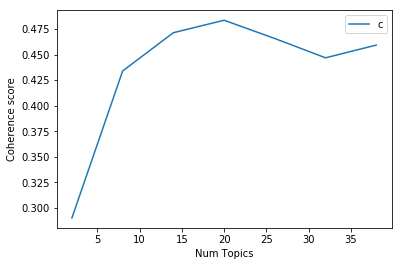

In [24]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2904
Num Topics = 8  has Coherence Value of 0.434
Num Topics = 14  has Coherence Value of 0.4713
Num Topics = 20  has Coherence Value of 0.4835
Num Topics = 26  has Coherence Value of 0.4657
Num Topics = 32  has Coherence Value of 0.4468
Num Topics = 38  has Coherence Value of 0.4593


** As we can see from the graph, considering 14 topics is pretty good idea**